## Library

soruce:(https://keras.io/examples/nlp/text_classification_with_transformer/)


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import nltk, random
import numpy as np
from nltk.corpus import movie_reviews
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

## Transformer Block

In [ ]:
# soruce:(https://keras.io/examples/nlp/text_classification_with_transformer/)
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm

## Embedding and Position

- And in Transformer-based networks, we need to include positional information of the tokens in the embeddings.
- Again, we use the `TokenAndPositionEmbedding` provided in `keras`'s tutorial.

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Data

Now let us re-cap the important steps of data preparation for deep learning NLP:
- Texts in the corpus need to be randomized in order.
- Perform the data splitting of **training and testing** sets (sometimes, validation set).
- Build `tokenizer` using the training set.
- All the input texts need to be transformed into integer sequences.
- All the class labels need to be coded in **numeric integers**(as logits for `binary_crossentropy` or labels for `sparse_categorical_crossentropy`) or **one-hot encodings** (for `categorical_crossentropy` of the  multi-class labels).
- Determine the **vocabulary size** and the **maximum length** of the input sequences.
- **Padding** the input sequences to uniform lengths (i.e., the `max_len`).


### Preprocessing Steps

Procedures:
- Load the corpus texts (`nltk.corpus.movie_reviews`)
- Build the keras `tokenizer()`
- Fit the `tokenizer` on the corpus texts
- Convert the word sequences of texts into integer sentences with the `tokenizer`
- Pad input lengths to uniform sizes

In [ ]:
train = pd.read_csv('train.tsv',sep='\t')
valid = pd.read_csv('dev.tsv',sep='\t')
test = pd.read_csv('test.tsv',sep='\t')

FileNotFoundError: ignored

In [ ]:
train.head()

In [ ]:
## Hyperparameters fot tokenizer
vocab_size = 30000
MAX_LEN = 256 
## texts vs. labels
texts = np.array(list(train["comment_text"]))
labels = np.array(list(train["label"]))


In [ ]:
## tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size,lower=False)
## fit tokenizer
tokenizer.fit_on_texts(texts)
## text to sequences
texts_to_int = tokenizer.texts_to_sequences(texts)
## pad sequences
texts_to_int_pad = keras.preprocessing.sequence.pad_sequences(texts_to_int,
                                                              maxlen=MAX_LEN,
                                                              truncating='post',
                                                              padding='post')

In [ ]:
## X and y for train and val
x_train = texts_to_int_pad
y_train = labels

In [ ]:
## X and y for train and val
x_train = texts_to_int_pad
y_train = labels

## Perform same vectorization on testing set
x_val_text = np.array(list(valid["comment_text"]))

x_val = keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(x_val_text),
    maxlen=MAX_LEN,
    truncating='post',
    padding='post'
)
    
y_val = np.array(list(valid["label"]))


## Define Classifier Architecture

- We then define the architecture of the network like before using `keras` Sequential or Functional API.
- The `TransformerBlock` and `TokenAndPositionEmbedding` function as like the other `keras.layers`.

In [ ]:
"""
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
"""

In [ ]:

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

## Using Sequential API
model = keras.Sequential([
                          layers.Input(shape=(MAX_LEN, )),
                          #1. Tokenization & embedding of the sentence
                          TokenAndPositionEmbedding(MAX_LEN, vocab_size, embed_dim),
                          #2. Transformer block
                          TransformerBlock(embed_dim, num_heads, ff_dim),
                          #3. Pooling
                          layers.GlobalAveragePooling1D(),
                          #4. Dropout & Dense
                          layers.Dropout(0.12),
                          layers.Dense(ff_dim, activation='relu'),
                          layers.Dropout(0.12),
                          layers.Dense(1, activation='sigmoid') 
                        ])


In [ ]:
model.summary()

In [ ]:
#First time in actually setting the model
keras.utils.plot_model(model, show_shapes=True)

## Training

In [ ]:
import tqdm
import tensorflow_addons as tfa
# initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar()

In [ ]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_train,y_train,
                    batch_size=128, epochs=32,
                    validation_data=(x_val, y_val),
                    callbacks = [tqdm_callback],
                    verbose=0)

## Ploting Training Results

In [ ]:
import matplotlib
from matplotlib import pyplot as plt

In [ ]:
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper left')
plt.show()

In [ ]:
model.save('/content')

# Make prediction

In [ ]:
## Perform same vectorization on testing set
x_test_text = np.array(list(test["comment_text"]))

x_test = keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(x_test_text),
    maxlen=MAX_LEN,
    truncating='post',
    padding='post'
)
    
y_test = np.array(list(test["label"]))


In [ ]:
preds = model.predict(x_test)

In [ ]:
#(1-p,p) pair for negative/positive values
preds_final = np.array([[float(1 - x), float(x)] for x in preds])

In [ ]:
preds_final[:5]

In [ ]:
y_test[:5]

In [ ]:
#Need conversion for negative
final_preds_converted = []
for i,x in enumerate(preds_final):
  if x[0]>x[1]:
    final_preds_converted.append(0)
  else:
    final_preds_converted.append(1)

In [ ]:
final_preds_converted[:5]

In [ ]:
import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Prediction Accuracy is",sklearn.metrics.accuracy_score(y_test, final_preds_converted))
print("\n\n")
print(classification_report(y_test, final_preds_converted))
print("\n\n")
print(confusion_matrix(y_test, final_preds_converted))

## 추가적으로

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

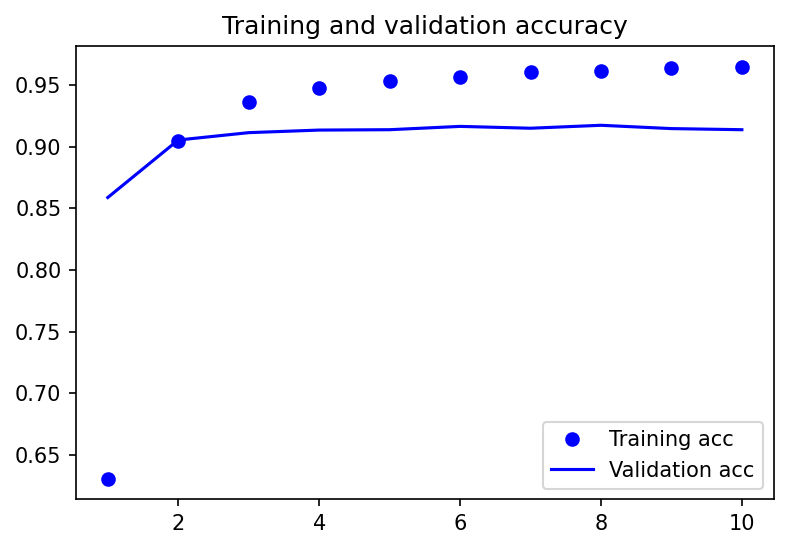

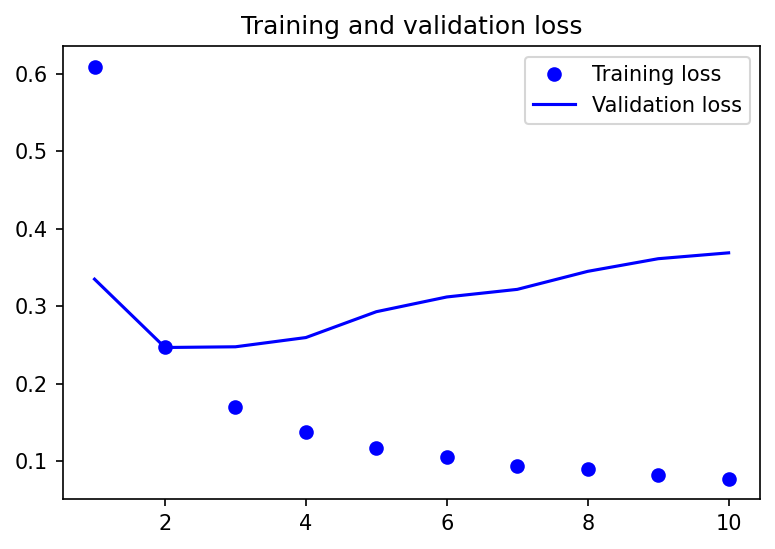

In [ ]:
plot1(history)

- Given the small corpus size, it is clear to see that our model starts to overfit the training set quite a bit after the first few epochs (e.g, after the fourth epoch).
- In real application development, we may improve the model by:
    - increasing the datasets
    - increasing the embedding dimensions
    - using pre-trained embeddings
    - playing with the transformer blocks in terms of depths and widths of the layers
    - including dropouts, regularization, and normalization

## References

- This unit is based on the official keras tutorial: [Text classification with transfomer](https://keras.io/examples/nlp/text_classification_with_transformer/)
- Please read Peter Bloem's blog post on Transformers: [Transformers From Scratch](http://peterbloem.nl/blog/transformers). Highly recommended! Very comprehensive introduction of the attention mechanism and transformers.